# NLP- COMPLAINT CLASSIFIER

For a service provider, customer complaints may carry a negative connotation; however, we should look to complaints as insights for several reasons:

- They are often a good indicator of what is going wrong. 
- They can highlight to management not only about challenges with people and processes, but also can provide ideas for new products and services.
- They provide an opportunity for the service provider to resolve the customer’s problems on time and thus reduce dissatisfaction levels.
- Customers who have had a problem resolved by a service provide effeciently, often have a stronger loyalty to the company compared with those that have never had a problem

Reference
https://horvay.dev/complaint-classifier/


![TOPIC MODELING](https://user-images.githubusercontent.com/54467567/87732467-a96f0780-c792-11ea-9d14-a4e60237fdf5.PNG)


In [49]:
# LIBRARIES

import os
import pandas as pd
import glob
import numpy as np
import warnings

import numpy as np
import pandas as pd
import re
import pickle
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, save
from bokeh.models import ColumnDataSource
from bokeh.transform import cumsum
from bokeh.io import curdoc
curdoc().theme = 'dark_minimal'


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
# Try to make it Comcast (new logo after NBC merge) themed
peacock_theme = ['#cc004c','#f37021','#fcb711','#6460aa','#0089d0','#0db14b','#ffc0cb','#00ffff']

In [56]:
# FILE INGESTION

customer_complaint = pd.DataFrame()
customer_reviews = pd.DataFrame()

for filename in glob.glob(r'D:\New_files\Github\Customer Complaints - NLP\*'):
    #print(file_name.split('\\')[4])
    print(filename)
    if filename.split('\\')[4].find('consumeraffairs')> 0:
        customer_reviews = pd.read_csv(filename, low_memory=False)
        print('consumer reviews file created')
    else:
        customer_complaint = pd.read_csv(filename, low_memory=False)
        print('cusomter complaint file created')
        

D:\New_files\Github\Customer Complaints - NLP\comcast_consumeraffairs_complaints.csv
consumer reviews file created
D:\New_files\Github\Customer Complaints - NLP\comcast_fcc_complaints_2015.csv
cusomter complaint file created


In [57]:
# CALCULATE CSAT SCORE : no of customers with more than 4 / no of reviews

customer_review = len(customer_reviews.loc[customer_reviews['rating']>=4])/len(customer_reviews)
print("Comcast's Customer Satisfaction Score calculated from ConsumerAffairs is {:.2f}%".format(customer_review*100))


Comcast's Customer Satisfaction Score calculated from ConsumerAffairs is 0.90%


![TEXT CLASSIFIER](https://user-images.githubusercontent.com/54467567/87732511-cd324d80-c792-11ea-9afb-6998ddd171c2.PNG)

In [62]:
# PREPROCESSING TEXT

ca_df = customer_reviews
fcc_df = customer_complaint

from spacy.lang.en import English
nlp = English()

customize_stop_words = ['comcast', 'i', 'fcc', 'hello', 'service', 'services', 'issue', 'issues', 'problem', 'problems', 'xfinity', 'customer', 'complaint', '$']

for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

def preprocess(verbatim):
    """
    Tokenizes, removes stopwords, and lemmatizes a verbatim text
    
    verbatim: a free-form text complaint
    """
    # Every verbatim ends with the FCC follow up, let's remove this.
    verbatim = verbatim.split('\n')[0].lower()
    doc = nlp(verbatim)
    sent = []
    for word in doc:
        # If it's not a stop word or punctuation mark, add it to our article!
        if word.text != 'n' and not word.is_stop and not word.is_punct and not word.like_num:
            # We add the lematized version of the word
            sent.append(word.lemma_.lower())
    return sent

# Tokenize each complaint
docs = fcc_df['Description'].apply(lambda verbatim: preprocess(verbatim))
docs[0]

['contacting',
 'internet',
 'technical',
 'support',
 'months',
 'resolve',
 'slow',
 'internet',
 'speed',
 'permanent',
 'resolution',
 'sent',
 'techs',
 'residence',
 'replaced',
 'hardware']

[('internet', 533), ('billing', 294), ('data', 220), ('speed', 121), ('cap', 106), ('caps', 79), ('practices', 73), ('speeds', 72), ('charges', 71), ('bill', 64), ('unfair', 59), ('cable', 56), ('throttling', 54), ('slow', 49), ('usage', 47), ('poor', 45), ('pricing', 42), ('price', 40), ('connection', 37), ('business', 33), ('contract', 30), ('phone', 30), ('false', 27), ('charged', 27), ('account', 26), ('charging', 25), ('high', 25), ('fees', 24), ('deceptive', 23), ('charge', 23)]


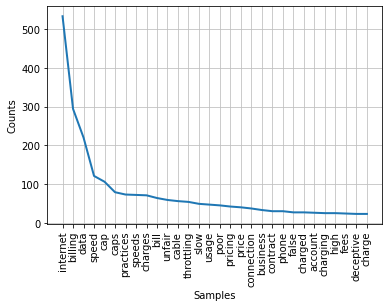

In [64]:
# NLTK FREQUENCY DISTRIBUTION

import nltk
from nltk import FreqDist
cats = fcc_df['Customer Complaint'].apply(lambda verbatim: preprocess(verbatim))
filtered_complaints = [c for cl in cats for c in cl]
fdist = FreqDist(filtered_complaints)
print(fdist.most_common(30))
fdist.plot(30);

### LDA
Latent Dirichlet Allocation (LDA) is a probabilistic model that assumes that every topic is a bag of words and every document is a bag of topics that each can be chosen with from the bag with some probability.

LDA is an unsupervised learning method. The number of topics, k, are left to us to determine and the interpretation of the topics is also left to us.

In [66]:
import gensim
from gensim.corpora import Dictionary

dictionary = Dictionary(docs)

print('Distinct words in initial documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 30% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.3)

print('Distinct words after removing rare and common words:', len(dictionary))

Distinct words in initial documents: 7248
Distinct words after removing rare and common words: 1149


In [68]:
from gensim.models import CoherenceModel, LdaModel
import pyLDAvis.gensim

corpus = [dictionary.doc2bow(doc) for doc in docs]
num_topics = 8

filename = 'lda_model.pickle'
model = []
found = False
try: 
    infile = open(filename,'rb')
    model = pickle.load(infile)
    infile.close()
    found = True
    print('Model found..loaded.')
except:
    print('Model not found!')

if not found:
    %time model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=20, workers=2)
    outfile = open(filename,'wb')
    pickle.dump(model, outfile)
    outfile.close()

Model not found!
Wall time: 32.5 s


In [69]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.127007 -0.087797       1        1  17.414042
4     -0.191735 -0.038525       2        1  17.196932
1     -0.112238 -0.027729       3        1  16.532335
6      0.005005 -0.075632       4        1  13.948938
7     -0.050383  0.200739       5        1  13.163097
5      0.171425  0.121661       6        1  11.484719
2      0.013840  0.018119       7        1   6.156442
0      0.291092 -0.110837       8        1   4.103495, topic_info=         Term        Freq       Total Category  logprob  loglift
368      data  450.000000  450.000000  Default  30.0000  30.0000
84      cable  636.000000  636.000000  Default  29.0000  29.0000
9       speed  535.000000  535.000000  Default  28.0000  28.0000
99       bill  884.000000  884.000000  Default  27.0000  27.0000
154    speeds  280.000000  280.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
55     signed   25.202105  186.778519   Topic8  -4.5918   1.1903
621  provided   21.644962   82.634521   Topic8  -4.7440   1.8537
52    monthly   22.970970  164.831268   Topic8  -4.6845   1.2226
62      usage   22.863436  168.936096   Topic8  -4.6892   1.1933
603      cost   21.810701  129.524033   Topic8  -4.7364   1.4119

[507 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
262       5  0.471448  105mbps
262       6  0.052383  105mbps
262       7  0.471448  105mbps
144       3  0.079578   50mbps
144       4  0.185682   50mbps
...     ...       ...      ...
65        4  0.173486    years
65        5  0.184001    years
65        6  0.110400    years
65        7  0.178744    years
65        8  0.073600    years

[1597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 7, 8, 6, 3, 1])

In [70]:
# MODEL EVALUATION

from sklearn.metrics.pairwise import cosine_similarity

fcc_df_super = fcc_df.copy()

fcc_df_super['Tokens'] = docs

docs_upper = fcc_df_super['Tokens'].apply(lambda l: l[:int(len(l)/2)])
docs_lower = fcc_df_super['Tokens'].apply(lambda l: l[int(len(l)/2):])

In [71]:
corpus_upper = [dictionary.doc2bow(doc) for doc in docs_upper]
corpus_lower = [dictionary.doc2bow(doc) for doc in docs_lower]

# Using the corpus LDA model tranformation
lda_corpus_upper = model[corpus_upper]
lda_corpus_lower = model[corpus_lower]

In [72]:
from collections import OrderedDict
def get_doc_topic_dist(model, corpus, kwords=False): 
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    
    model: the LDA model
    corpus: the documents
    kwords: if True adds and returns the keys
    '''
    top_dist =[]
    keys = []
    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.asarray(vals)]
        if kwords:
            keys += [np.asarray(vals).argmax()]

    return np.asarray(top_dist), keys

In [73]:
top_dist_upper, _ = get_doc_topic_dist(model, lda_corpus_upper)
top_dist_lower, _ = get_doc_topic_dist(model, lda_corpus_lower)

print("Intra-similarity:", np.mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1, c2 in zip(top_dist_upper, top_dist_lower)]))

random_pairs = np.random.randint(0, len(fcc_df_super['Description']), size=(400, 2))

print("Inter-similarity:", np.mean([cosine_similarity(top_dist_upper[0].reshape(1, -1), top_dist_lower[1].reshape(1, -1))]))

Intra-similarity: 0.728311
Inter-similarity: 0.29367015


In [74]:
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('\nTopic {}\n'.format(str(i)))
    for term, frequency in model.show_topic(i, topn=10):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

term                 frequency


Topic 0

cable                0.054
dollars              0.035
package              0.035
price                0.023
month                0.022
drink                0.019
television           0.018
world                0.016
bill                 0.016
sandwich             0.015

Topic 1

said                 0.029
called               0.020
cable                0.019
told                 0.016
time                 0.014
tv                   0.014
phone                0.013
new                  0.013
got                  0.009
rep                  0.009

Topic 2

month                0.030
contract             0.028
pay                  0.020
year                 0.016
business             0.014
bill                 0.013
signed               0.012
mail                 0.012
months               0.011
company              0.011

Topic 3

bill                 0.034
account              0.028
told                 0.027
modem                0.025
credit    

In [75]:
top_labels = {0: 'Internet Speed', 1:'Moving Services', 2:'Customer Service', 3:'Billing', 4:'Data Caps', 5: 'Business Contracts', 6:'Missed Appointments', 7: 'Pricing'}

In [76]:
# ASSINGING TOPICS BASED ON IMPORTANT WORDS

from sklearn.feature_extraction.text import TfidfVectorizer

tvectorizer = TfidfVectorizer(input='content', analyzer = 'word', lowercase=True, stop_words='english',
                                  tokenizer=preprocess, ngram_range=(1,3), min_df=40, max_df=0.20,
                                  norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

dtm = tvectorizer.fit_transform(fcc_df_super['Description']).toarray()

In [77]:
top_dist, lda_keys= get_doc_topic_dist(model, corpus, True)
features = tvectorizer.get_feature_names()

In [78]:
top_words = []
for n in range(len(dtm)):
    inds = np.int0(np.argsort(dtm[n])[::-1][:4])
    top_words += [', '.join([features[i] for i in inds])]
    
fcc_df_super['Description Top Words'] = pd.DataFrame(top_words)
fcc_df_super['Topic'] = pd.DataFrame(lda_keys)
# Fill missing values with dummy
fcc_df_super['Topic'].fillna(-1, inplace=True)

In [88]:
fcc_df_super['Topic'] = fcc_df_super['Topic'].map(top_labels)

In [89]:
fcc_df_super[['Ticket #','Customer Complaint','Description','Description Top Words','Topic']].head()

,Ticket #,Customer Complaint,Description,Description Top Words,Topic
0,250635,Comcast Cable Internet Speeds,I have been contacting Comcast Internet Techni...,"resolution, support, resolve, internet speed",Pricing
1,223441,Payment disappear - service got disconnected,Back in January 2015 I made 2 payments: One fo...,"payment, care, number, account",Billing
2,242732,Speed and Service,Our home is located at in Acworth Georgia 3010...,"high speed internet, billed, high speed, speed...",Missed Appointments
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,Comcast in the Atlanta area has just put into ...,"gb, usage, cap, area",Business Contracts
4,307175,Comcast not working and no service to boot,I have been a customer of Comcast of some sort...,"years, like, gone, forced",Moving Services


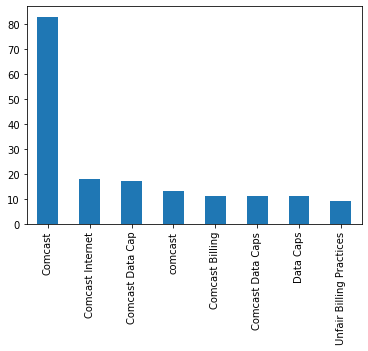

In [95]:
fcc_df_super['Customer Complaint'].value_counts().head(8).plot(kind='bar');

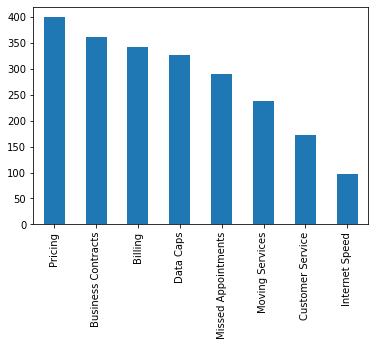

In [96]:
fcc_df_super['Topic'].value_counts().head(8).plot(kind='bar');

# END